In [1]:
# Pre-processing dependencies

from scipy.io import loadmat
from scipy.io import savemat
from scipy.stats import kurtosis, skew, entropy
from scipy import signal
import pandas as pd
import numpy as np

from sklearn import preprocessing

In [2]:
# Classifier dependencies

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from function import classification

In [3]:
# Plotting dependencies

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
involuntary = loadmat('dataset/jap_blink_involuntary.mat')['jap_blink_involuntary']
channels = ["Fp1","Fp2", "F3", "F4", "T3", "C3", "Cz", "C4", "T4", "P3", "Pz", "P4", "O1", "O2"]

Fs = 256
eeg_bands = {'delta': (0, 4),
             'eog': (3, 4),
             'theta': (4, 8),
             'alpha': (8, 12),
             'beta': (12, 30),
             'gamma': (30, 45)}

In [5]:
features = pd.DataFrame()

# channels x points x epochs (14x1024x394)
def extract_data(filename, dataframe, is_voluntary):
    data = loadmat('dataset/' + filename + '.mat')[filename]

    # iterate per epoch
    for i in range (data.shape[2]):
        sub_data = data[:, :, i]
        new_record = {}
        # iterate per channel
        for j in range (sub_data.shape[0]):

            #sub2_data is the signal
            sub2_data = data[j,:,i]
            new_record[channels[j] + '_mean'] = np.mean(sub2_data)
            new_record[channels[j] + '_median'] = np.median(sub2_data)
            new_record[channels[j] + '_min'] = np.min(sub2_data)
            new_record[channels[j] + '_max'] = np.max(sub2_data)
            new_record[channels[j] + '_range'] = np.max(sub2_data) - np.min(sub2_data)
            new_record[channels[j] + '_std'] = np.std(sub2_data)
            new_record[channels[j] + '_var'] = np.var(sub2_data)
            new_record[channels[j] + '_kurtosis'] = kurtosis(sub2_data)
            new_record[channels[j] + '_skew'] = skew(sub2_data)

            # if channels[j] in ['Fp1', 'Fp2']:
            f, sub2_psd = signal.welch(sub2_data, Fs, nperseg=1024)
            sub2_psd = 10 * np.log10(sub2_psd)

            new_record['f_max_power'] = f[np.argmax(sub2_psd)]

            for band in ['delta', 'eog', 'theta']:
                # f_indices = np.where((f >= eeg_bands[band][0]) & (f < eeg_bands[band][1]))
                f_indices = f[(f >= eeg_bands[band][0]) & (f < eeg_bands[band][1])]
                psd_indices = sub2_psd[(f >= eeg_bands[band][0]) & (f < eeg_bands[band][1])]
                prefix = channels[j] + '_' + band
                new_record[prefix + '_psd_mean'] = np.mean(psd_indices)
                new_record[prefix + '_psd_median'] = np.median(psd_indices)
                new_record[prefix + '_psd_min'] = np.min(psd_indices)
                new_record[prefix + '_psd_max'] = np.max(psd_indices)
                new_record[prefix + '_psd_range'] = np.max(psd_indices)- np.min(psd_indices)
                new_record[prefix + '_psd_std'] = np.std(psd_indices)
                new_record[prefix + '_psd_var'] = np.var(psd_indices)

        new_record['is_voluntary'] = is_voluntary
        dataframe = pd.concat([dataframe, pd.DataFrame([new_record])], ignore_index=True)
    return dataframe

In [6]:
features = extract_data('jap_blink_involuntary', features, 0)
features = extract_data('jap_blink_voluntary', features, 1)

In [7]:
channels[1] + '_mean'

'Fp2_mean'

In [8]:
features

,Fp1_mean,Fp1_median,Fp1_min,Fp1_max,Fp1_range,Fp1_std,Fp1_var,Fp1_kurtosis,Fp1_skew,f_max_power,...,O2_eog_psd_std,O2_eog_psd_var,O2_theta_psd_mean,O2_theta_psd_median,O2_theta_psd_min,O2_theta_psd_max,O2_theta_psd_range,O2_theta_psd_std,O2_theta_psd_var,is_voluntary
0,-0.046735,0.063639,-53.271559,77.853305,131.124864,16.018676,256.597974,7.092223,0.660813,0.50,...,3.936633,15.497076,-22.398267,-20.346000,-30.378366,-15.792256,14.586110,4.916005,24.167109,0
1,0.001362,0.409763,-71.513945,88.395715,159.909660,18.830967,354.605317,6.728835,-0.007676,0.50,...,2.959732,8.760015,-19.945216,-19.406785,-32.685664,-12.962887,19.722777,5.036833,25.369687,0
2,-0.895459,-0.579754,-89.130934,75.969075,165.100010,22.821094,520.802351,4.298817,-1.024268,0.50,...,4.325814,18.712670,-26.292485,-23.462234,-53.066236,-20.628571,32.437664,7.842528,61.505252,0
3,-0.339240,0.226092,-54.124587,96.766259,150.890846,14.960617,223.820072,10.700343,0.972350,0.50,...,4.571764,20.901025,-23.726495,-21.595620,-37.358931,-14.737856,22.621075,5.743689,32.989959,0
4,0.322526,0.802425,-98.213821,116.997612,215.211433,24.903827,620.200615,7.588656,-0.014908,1.00,...,6.352335,40.352155,-11.022964,-10.901569,-30.281236,-3.899003,26.382233,6.432869,41.381805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,0.154791,2.088616,-204.904409,145.771644,350.676053,53.052647,2814.583406,4.630940,-1.231858,0.75,...,2.746850,7.545184,-28.937721,-27.937709,-47.798313,-19.376594,28.421719,6.819313,46.503028,1
857,-0.051594,1.757046,-192.237970,170.266708,362.504677,52.622683,2769.146740,4.156377,-0.944851,0.50,...,2.184870,4.773658,-30.015835,-28.682130,-42.081488,-22.056613,20.024876,5.108310,26.094832,1
858,0.144837,2.572012,-205.625686,168.198200,373.823886,52.996413,2808.619793,4.331131,-0.966810,0.50,...,2.178069,4.743984,-30.067950,-29.531727,-44.532530,-24.811725,19.720805,4.911524,24.123065,1
859,-0.370997,0.837305,-207.828832,159.905186,367.734019,52.726619,2780.096399,4.760876,-1.046627,0.50,...,4.300259,18.492230,-26.481693,-27.057778,-34.975872,-20.069522,14.906350,3.725420,13.878758,1


In [9]:
# Preparing the x (inputs) and y (output)
x = features.loc[:, features.columns != 'is_voluntary']
y = features.loc[:, features.columns == 'is_voluntary']
results = pd.DataFrame()

In [10]:
# Normalization on inputs
def normalize_mms(input_df):
    scaler = preprocessing.RobustScaler()
    result = scaler.fit_transform(input_df)
    return pd.DataFrame(result, index=input_df.index, columns=input_df.columns)

x = normalize_mms(x)
x

,Fp1_mean,Fp1_median,Fp1_min,Fp1_max,Fp1_range,Fp1_std,Fp1_var,Fp1_kurtosis,Fp1_skew,f_max_power,...,O2_eog_psd_range,O2_eog_psd_std,O2_eog_psd_var,O2_theta_psd_mean,O2_theta_psd_median,O2_theta_psd_min,O2_theta_psd_max,O2_theta_psd_range,O2_theta_psd_std,O2_theta_psd_var
0,-0.125884,-0.499506,0.697730,-0.999195,-0.961266,-0.776578,-0.613088,-0.053609,0.285258,0.0,...,-0.067082,-0.008426,-0.008146,0.181497,0.360812,0.505296,0.029275,-0.610574,-0.100394,-0.096725
1,0.002262,-0.078242,0.285588,-0.789177,-0.632202,-0.541060,-0.456232,-0.157493,-0.385358,0.0,...,-0.498519,-0.380186,-0.322053,0.562569,0.503444,0.251709,0.442693,0.121662,-0.033531,-0.032695
2,-2.387163,-1.282575,-0.112425,-1.036731,-0.572867,-0.206904,-0.190242,-0.852180,-1.405186,0.0,...,-0.041453,0.139677,0.141682,-0.423455,-0.112429,-1.988249,-0.677392,1.934180,1.519081,1.891302
3,-0.905213,-0.301786,0.678458,-0.622425,-0.735304,-0.865186,-0.665547,0.977870,0.597788,0.0,...,0.289287,0.233273,0.243646,-0.024838,0.171041,-0.261914,0.183340,0.534817,0.357628,0.373038
4,0.857949,0.399664,-0.317631,-0.219391,0.000000,-0.032483,-0.031161,0.088310,-0.392613,2.0,...,0.814302,0.910868,1.149952,1.948605,1.795073,0.515971,1.767079,1.070973,0.739006,0.819852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,0.411046,1.965078,-2.728045,0.353824,1.548612,2.324864,3.480835,-0.757233,-1.613435,1.0,...,-0.415241,-0.461198,-0.378657,-0.834382,-0.792089,-1.409270,-0.494457,1.361703,0.952855,1.092525
857,-0.138829,1.561526,-2.441877,0.841796,1.683835,2.288857,3.408116,-0.892900,-1.325515,0.0,...,-0.710267,-0.675059,-0.507793,-1.001862,-0.905139,-0.780954,-0.886053,0.164726,0.006023,0.005915
858,0.384526,2.553415,-2.744340,0.800589,1.813235,2.320155,3.471291,-0.842942,-1.347544,0.0,...,-0.578125,-0.677647,-0.509176,-1.009958,-1.034162,-1.050339,-1.288621,0.121381,-0.102874,-0.099070
859,-0.989823,0.442117,-2.794115,0.635381,1.743616,2.297561,3.425641,-0.720088,-1.427615,0.0,...,0.157329,0.129952,0.131410,-0.452847,-0.658460,0.000000,-0.595706,-0.564924,-0.759238,-0.644516


Train acc: 0.8953488372093024
[[245  32]
 [ 31 294]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       277
           1       0.90      0.90      0.90       325

    accuracy                           0.90       602
   macro avg       0.89      0.89      0.89       602
weighted avg       0.90      0.90      0.90       602


Test acc: 0.8455598455598455
[[ 97  20]
 [ 20 122]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       117
           1       0.86      0.86      0.86       142

    accuracy                           0.85       259
   macro avg       0.84      0.84      0.84       259
weighted avg       0.85      0.85      0.85       259



C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


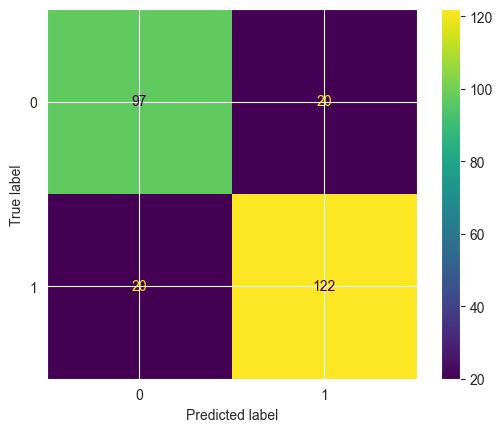

In [11]:
# Logistic Regression
LR = LogisticRegression(random_state=42)
accuracy, LR = classification.model_training(x, y.values.ravel(), LR)
results = pd.concat([results, pd.DataFrame([{'model': 'Logistic Regression', 'accuracy': accuracy}])], ignore_index=True)

C:\Users\Edwin Sanjaya\DataspellProjects\bci-finalproject\function\classification.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Train acc: 1.0
[[277   0]
 [  0 325]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       325

    accuracy                           1.00       602
   macro avg       1.00      1.00      1.00       602
weighted avg       1.00      1.00      1.00       602


Test acc: 0.8223938223938224
[[ 93  24]
 [ 22 120]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       117
           1       0.83      0.85      0.84       142

    accuracy                           0.82       259
   macro avg       0.82      0.82      0.82       259
weighted avg       0.82      0.82      0.82       259



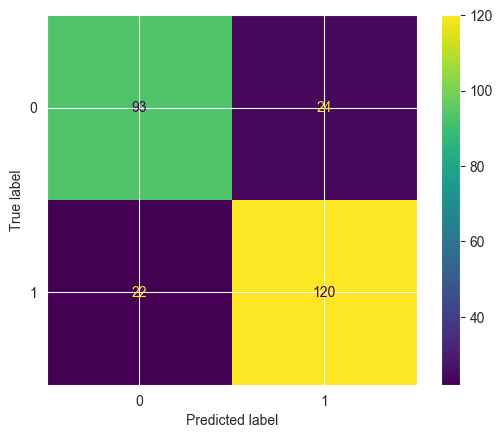

In [12]:
RF = RandomForestClassifier(random_state=42)
accuracy, RF = classification.model_training(x, y, RF)
results = pd.concat([results, pd.DataFrame([{'model': 'Random Forest', 'accuracy': accuracy}])], ignore_index=True)

C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train acc: 0.8787375415282392
[[240  37]
 [ 36 289]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       277
           1       0.89      0.89      0.89       325

    accuracy                           0.88       602
   macro avg       0.88      0.88      0.88       602
weighted avg       0.88      0.88      0.88       602


Test acc: 0.7722007722007722
[[ 90  27]
 [ 32 110]]
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       117
           1       0.80      0.77      0.79       142

    accuracy                           0.77       259
   macro avg       0.77      0.77      0.77       259
weighted avg       0.77      0.77      0.77       259



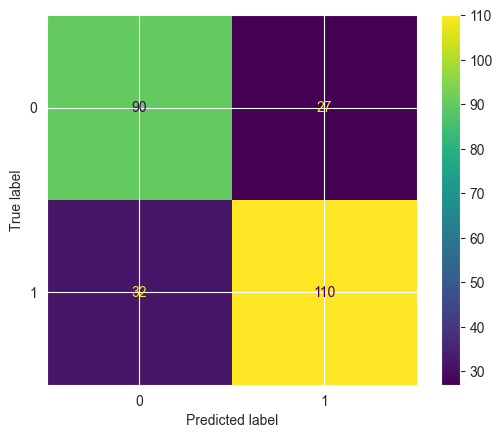

In [13]:
SVM = SVC(random_state=42)
accuracy, SVM = classification.model_training(x, y, SVM)
results = pd.concat([results, pd.DataFrame([{'model': 'Support Vector Machine', 'accuracy': accuracy}])], ignore_index=True)

Train acc: 1.0
[[277   0]
 [  0 325]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       325

    accuracy                           1.00       602
   macro avg       1.00      1.00      1.00       602
weighted avg       1.00      1.00      1.00       602


Test acc: 0.8571428571428571
[[ 99  18]
 [ 19 123]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       117
           1       0.87      0.87      0.87       142

    accuracy                           0.86       259
   macro avg       0.86      0.86      0.86       259
weighted avg       0.86      0.86      0.86       259



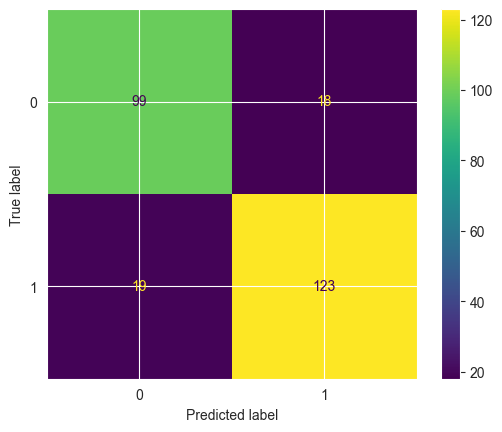

In [14]:
XGB = XGBClassifier()
accuracy, XGB = classification.model_training(x, y, XGB)
results = pd.concat([results, pd.DataFrame([{'model': 'XGBoost', 'accuracy': accuracy}])], ignore_index=True)

Train acc: 0.9568106312292359
[[272   5]
 [ 21 304]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       277
           1       0.98      0.94      0.96       325

    accuracy                           0.96       602
   macro avg       0.96      0.96      0.96       602
weighted avg       0.96      0.96      0.96       602


Test acc: 0.8378378378378378
[[ 95  22]
 [ 20 122]]
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       117
           1       0.85      0.86      0.85       142

    accuracy                           0.84       259
   macro avg       0.84      0.84      0.84       259
weighted avg       0.84      0.84      0.84       259



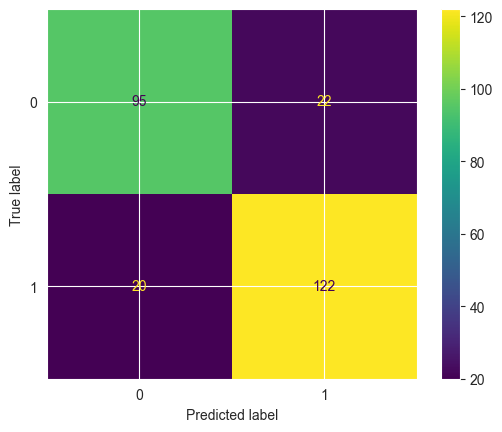

In [15]:
XGBRF = XGBRFClassifier()
accuracy, XGBRF = classification.model_training(x, y, XGBRF)
results = pd.concat([results, pd.DataFrame([{'model': 'XGBoost Random Forest', 'accuracy': accuracy}])], ignore_index=True)

C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train acc: 0.946843853820598
[[256  21]
 [ 11 314]]
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       277
           1       0.94      0.97      0.95       325

    accuracy                           0.95       602
   macro avg       0.95      0.95      0.95       602
weighted avg       0.95      0.95      0.95       602


Test acc: 0.7992277992277992
[[100  17]
 [ 35 107]]
              precision    recall  f1-score   support

           0       0.74      0.85      0.79       117
           1       0.86      0.75      0.80       142

    accuracy                           0.80       259
   macro avg       0.80      0.80      0.80       259
weighted avg       0.81      0.80      0.80       259



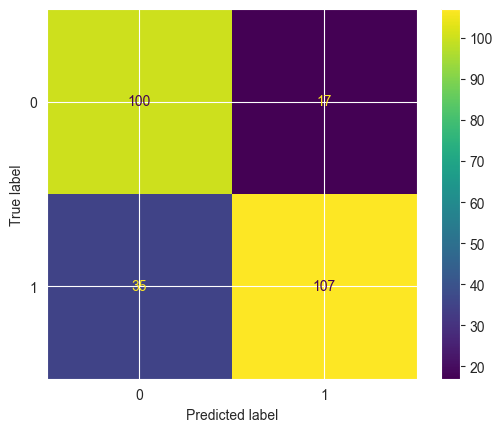

In [16]:
LDA = LinearDiscriminantAnalysis()
accuracy, LDA = classification.model_training(x, y, LDA)
results = pd.concat([results, pd.DataFrame([{'model': 'Linear Discriminant Analysis', 'accuracy': accuracy}])], ignore_index=True)

C:\Software\anaconda3\envs\bcifinal1\Lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Train acc: 0.8571428571428571
[[234  43]
 [ 43 282]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       277
           1       0.87      0.87      0.87       325

    accuracy                           0.86       602
   macro avg       0.86      0.86      0.86       602
weighted avg       0.86      0.86      0.86       602


Test acc: 0.749034749034749
[[ 84  33]
 [ 32 110]]
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       117
           1       0.77      0.77      0.77       142

    accuracy                           0.75       259
   macro avg       0.75      0.75      0.75       259
weighted avg       0.75      0.75      0.75       259



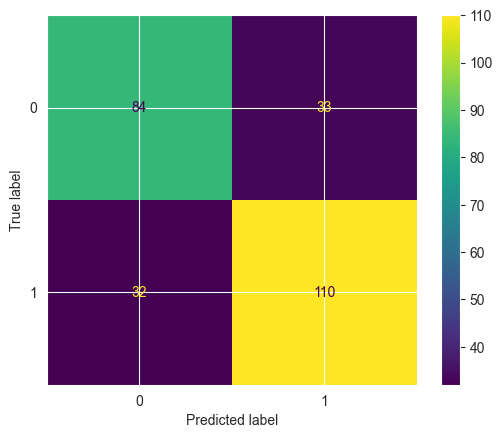

In [17]:
KNN = KNeighborsClassifier(n_neighbors=3)
accuracy, KNN = classification.model_training(x, y, KNN)
results = pd.concat([results, pd.DataFrame([{'model': 'K-Nearest Neighbors', 'accuracy': accuracy}])], ignore_index=True)

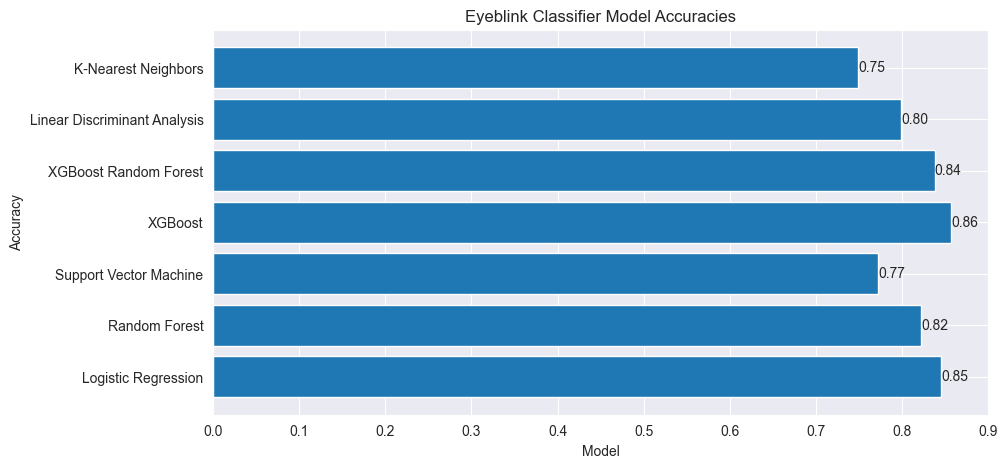

In [18]:
plt.figure(figsize=(10, 5))
bars = plt.barh(results['model'], results['accuracy'])
plt.title('Eyeblink Classifier Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.2f}',
             ha='left', va='center')
plt.show()